In [15]:
# Import all necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# One-hot encoding: convert numerical labels into one-hot encoding.
from sklearn.preprocessing import label_binarize

# Metrics.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [16]:
# Reset PN-sequence generator.
seed = 42
np.random.seed(seed)

### Criando exemplos de 3 classes.

In [17]:
# Define the number of different classes.
numberOfClasses = 3

# Number of examples.
N = 1000

# Create a 3-class dataset for classification.
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=N, centers=centers, random_state=seed)

### Plotando as 3 classes.

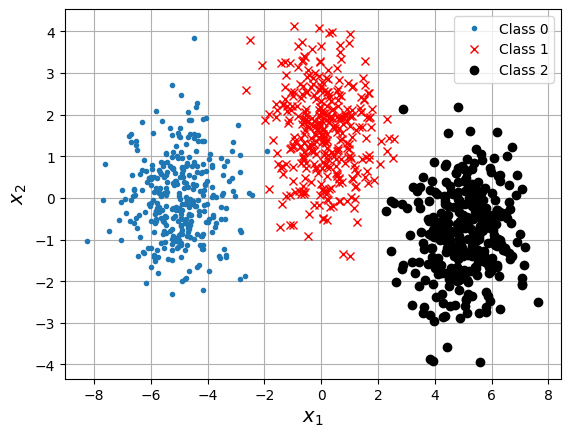

In [18]:
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)
idx2 = np.argwhere(y == 2)

plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Quantidade de exemplos por classe.

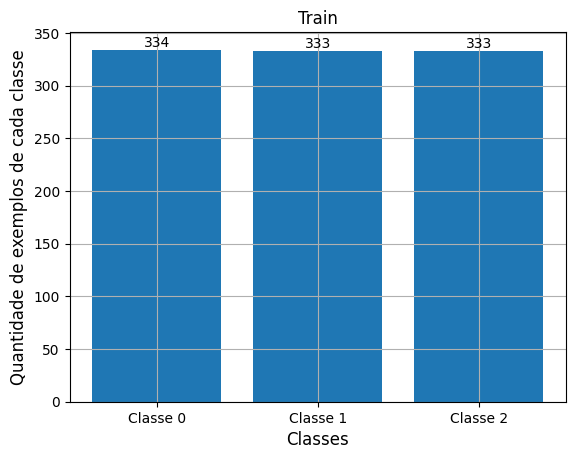

In [19]:
bars = plt.bar(['Classe 0','Classe 1', 'Classe 2'], [len(y[y==0]), len(y[y==1]), len(y[y==2])])
plt.bar_label(bars)
plt.grid()
plt.title('Train')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Quantidade de exemplos de cada classe', fontsize=12)
plt.show()

### Qual o formato mais apropriado para as funções discriminantes?

Após observar a figura, podemos concluir que o formato mais simples para as funções discriminantes é o da reta:

$$g(\textbf{x}) = \hat{a}_0 + \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

### Dividindo o conjunto total em conjuntos para treinamento e validação.

In [20]:
# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print('Tamanho do conjunto de treinamento:', len(y_train))
print('Tamanho do conjunto de validação:', len(y_test))

Tamanho do conjunto de treinamento: 700
Tamanho do conjunto de validação: 300


### Instanciando e treinando o classificador.

**Observações**:

+ Por padrão, o parâmetro `fit_intercept` da classe `LogisticRegression` é igual a `True`. Portanto, não é necessário concatenar o vetor com valores iguais a 1 (atributo de bias) às matrizes de atributos de treinamento e validação.
<br/>

+ Como estamos usando o formato mais apropriado (i.e., menos complexo possível) para as funções discriminantes, podemos desabilitar a regularização (que é habilitada por padrão), pois o modelo não irá sobreajustar.

In [21]:
# Instantiate LogisticRegression object for multi-class case.
model = LogisticRegression(penalty=None, random_state=seed)

# Train model.
model.fit(X_train, y_train)

LogisticRegression(penalty=None, random_state=42)

### Calculando a acurácia do modelo.

In [22]:
# Accuracy with trainning set.
y_pred_train = model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print('Acurácia treinamento:', acc_train)

# Accuracy with test set.
y_pred_test = model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print('Acurácia teste:', acc_test)

Acurácia treinamento: 1.0
Acurácia teste: 0.99


### Plotando as regiões de decisão.

**OBS:** Notem que a matriz de atributos criada para plotarmos as regiões de decisão também deve ter a mesma forma que as matrizes de atributos criadas para o treinamento e validação.

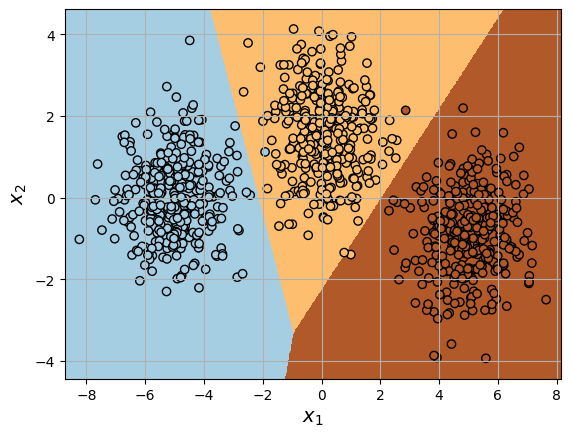

In [23]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()

plt.show()

### Plotando a matriz de confusão.

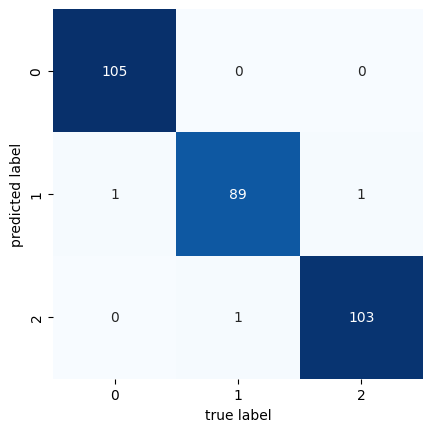

In [24]:
# Plot the confusion matrix.
mat = confusion_matrix(y_test, y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=range(numberOfClasses), yticklabels=range(numberOfClasses), cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Plotando as curvas ROC.

**Observações**:

+ Lembrem-se que a curva ROC é apropriada para problemas de **classificação binária**.
<br/>

+ No caso multiclasses, devemos utilizar as estratégias `um-contra-o-resto` ou `um-contra-um` e plotar várias curvas ROC de classificadores binários, ou seja, uma curva para cada uma das Q classes.
<br/>

+ Como temos 3 classes, usaremos a abordagem **`um-contra-o-resto`** para plotar 3 curvas ROC de 3 classificadores binários:
    + Classificador 1: classe 0 (+) contra classes 1 e 2 (-).
    + Classificador 2: classe 1 (+) contra classes 0 e 2 (-).
    + Classificador 3: classe 2 (+) contra classes 0 e 1 (-).
<br/>

+ Compararemos o desempenho dos classificadores binários com o desempenho de um **classificador binário puramente aleatório** (ou seja, um classificador que tem como saída a classe 0 ou 1 com a mesma probabilidade, ou seja, 50%).

#### Convertendo o vetor de rótulos de teste na codificação one-hot.

In [25]:
# Binarize the test targets.
y_test_bin = label_binarize(y_test, classes=range(numberOfClasses))

# Apresento os 10 primeiros valores.
print('Dimensões de entrada da função:', y_test.shape)
print('Entrada da função -> rótulos com valores inteiros:\n', y_test[0:10])
print('\nDimensões de saída da função:', y_test_bin.shape)
print('Saída da função -> rótulos no formato one-hot:\n', y_test_bin[0:10,:])

Dimensões de entrada da função: (300,)
Entrada da função -> rótulos com valores inteiros:
 [0 0 2 0 2 1 1 2 1 0]

Dimensões de saída da função: (300, 3)
Saída da função -> rótulos no formato one-hot:
 [[1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]]


**Observação**:

+ Percebam que após a conversão na codificação *one-hot*, através da função `label_binarize`, **cada coluna** da `matriz` resultante está no formato `um-contra-o-resto`, onde apenas os exemplos da classe positiva têm o valor igual a 1 e todos os demais exemplos (classe negativa) são iguais a 0.

#### Calculando as probabilidades de cada exemplo.

Para plotar as curvas ROC, precisamos das probabilidades de cada classe para os exemplos de entrada, na sequência, variamos o valor do limiar de discretização, $T$.

**Observação**

+ Para obtermos as probabilidades de cada classe para os exemplos de entrada, devemos usar o método `predict_proba` da classe `LogisticRegression`.

In [26]:
# Getting the probabilities for each class.
y_prob = model.predict_proba(X_test)

print('Rótulos:')
print(y_test_bin[0:10])

print('\nProbabilidades:')
print(y_prob[0:10, :])

Rótulos:
[[1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]]

Probabilidades:
[[1.00000000e+00 1.01292382e-12 1.65199688e-42]
 [9.99999996e-01 4.18922393e-09 1.30021322e-27]
 [2.04636928e-65 5.12938475e-24 1.00000000e+00]
 [1.00000000e+00 1.02508287e-23 2.03664322e-52]
 [5.23901689e-46 4.57815719e-16 1.00000000e+00]
 [2.21037908e-08 9.99999978e-01 4.80658119e-25]
 [1.34719879e-11 1.00000000e+00 2.74184842e-11]
 [1.09891167e-50 2.83552070e-17 1.00000000e+00]
 [1.91143358e-12 1.00000000e+00 1.07893240e-12]
 [1.00000000e+00 8.33513647e-24 5.64534271e-64]]


#### Plotando as curvas ROC.

**OBS**.: Plotamos **uma curva ROC para cada coluna** das matrizes de probabilidade e de rótulos, pois para cada coluna, uma classe é a postitiva e as demais são unidas para formar a classe negativa.

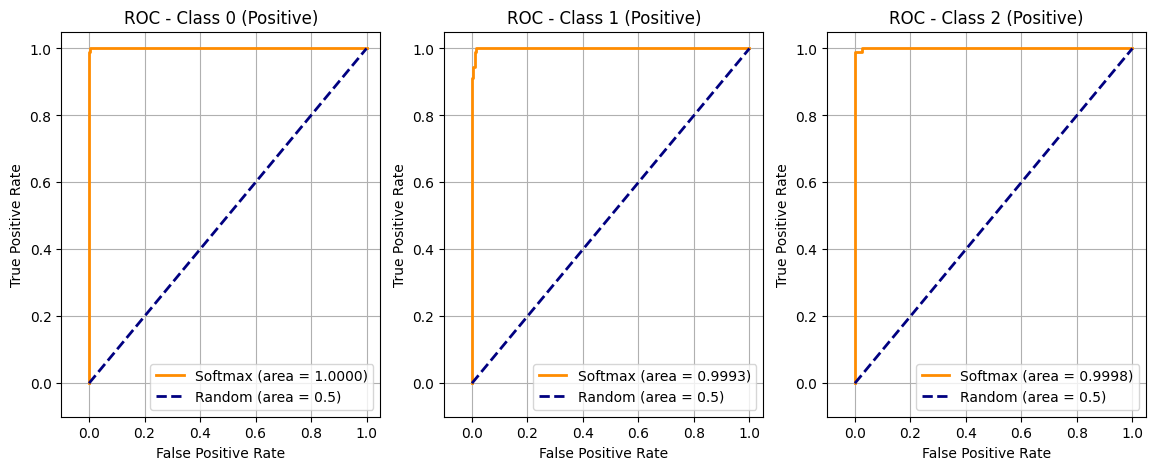

In [27]:
# Compute ROC curve and ROC area for each class.
plt.figure(figsize=(14, 5))
lw = 2
for i in range(numberOfClasses):
    # Calculating ROC curve and ROC AUC.
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    # Plotting ROC curve for class i.
    ax = plt.subplot(1, numberOfClasses, i + 1)
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Softmax (area = %1.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random (area = 0.5)')
    plt.xlim([-0.1, 1.05])
    plt.ylim([-0.1, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Class '+ str(i) +' (Positive)')
    plt.legend(loc="lower right")
    plt.grid()

plt.show()

### Relatório com métricas de classificação.

In [28]:
print(classification_report(y_test, y_pred_test, digits=6))

              precision    recall  f1-score   support

           0   1.000000  0.990566  0.995261       106
           1   0.978022  0.988889  0.983425        90
           2   0.990385  0.990385  0.990385       104

    accuracy                       0.990000       300
   macro avg   0.989469  0.989947  0.989690       300
weighted avg   0.990073  0.990000  0.990020       300



#### Observações:

+ O parâmetro `digits` configura o número desejado de casas decimais após a vírgula.


+ `macro avg` dá média aritmética **simples** das métricas para cada classe.
    + Ela atribui o mesmo peso para cada classe, independentemente do número de amostras em cada uma delas.


+ `weighted avg` dá média aritmética **ponderada** das métricas para cada classe.
    + Ela atribui pesos diferentes para cada classe, levando em consideração o número de amostras em cada uma delas.
    + Assim, classes com mais amostras tem uma contribuição maior no cálculo da métrica.